In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats
from nba_api.stats.endpoints.leaguehustlestatsteam import LeagueHustleStatsTeam
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats

In [4]:
df = pd.read_csv('pbp_data/2021-22.csv')

In [5]:
full_df = pd.read_csv('pbp_data/2021-22.csv')

full_df = full_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
full_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in full_df.GAME_ID.astype(str)]

In [6]:
bad_pass_steals = full_df.loc[(full_df.EVENTMSGTYPE == 5) & (full_df.EVENTMSGACTIONTYPE == 1)]

In [7]:
lost_ball_steals = full_df.loc[(full_df.EVENTMSGTYPE == 5) & (full_df.EVENTMSGACTIONTYPE == 2)]

In [8]:
bad_pass_counts = bad_pass_steals.PLAYER2_NAME.value_counts().to_frame().reset_index().rename(columns={'index': 'PLAYER_NAME', 'PLAYER2_NAME': 'BAD_PASS_STEAL'})

In [9]:
lost_ball_counts = lost_ball_steals.PLAYER2_NAME.value_counts().to_frame().reset_index().rename(columns={'index': 'PLAYER_NAME', 'PLAYER2_NAME': 'LOST_BALL_STEAL'})

In [10]:
merged_df = pd.merge(left=bad_pass_counts, right=lost_ball_counts, on='PLAYER_NAME')

In [11]:
merged_df.loc[:, 'TOTAL_STEALS'] = merged_df.BAD_PASS_STEAL + merged_df.LOST_BALL_STEAL

In [12]:
merged_df.sort_values(by='TOTAL_STEALS', ascending=False)

,PLAYER_NAME,BAD_PASS_STEAL,LOST_BALL_STEAL,TOTAL_STEALS
4,Chris Paul,48,35,83
1,Dejounte Murray,52,29,81
3,Marcus Smart,48,26,74
0,Tyrese Haliburton,56,15,71
8,Donovan Mitchell,45,19,64
65,Fred VanVleet,26,38,64
12,Lonzo Ball,42,22,64
47,Gary Trent Jr.,30,33,63
5,LaMelo Ball,47,15,62
6,De'Anthony Melton,47,14,61


In [13]:
player_stats = LeagueDashPlayerStats(season='2021-22', per_mode_detailed='PerGame').get_data_frames()[0]

In [14]:
full_merged = pd.merge(left=merged_df, right=player_stats, on='PLAYER_NAME')

In [15]:
full_merged.loc[:, "BAD_PASS_STEAL_G"] = full_merged.BAD_PASS_STEAL / full_merged.GP
full_merged.loc[:, "LOST_BALL_STEAL_G"] = full_merged.LOST_BALL_STEAL / full_merged.GP

In [ ]:
full_merged.S

In [17]:
full_merged = full_merged.sort_values(by='TOTAL_STEALS', ascending=False)

In [22]:
plt.style.use('fivethirtyeight')

In [19]:
top_players = full_merged.iloc[:40]

In [20]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter


import matplotlib.ticker as mtick

zoom = 0.7
team_root_dir = '../../team_logos_id/'
player_root_dir = 'player_imgs/'

def get_player_img(player_id):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

def get_team_img(team_id):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{team_id}.png'), zoom=zoom)

Text(0.5, 1.0, 'How do top ball stealers get their steals?\n(top 40 players in steals per game - on ball vs interceptions)')

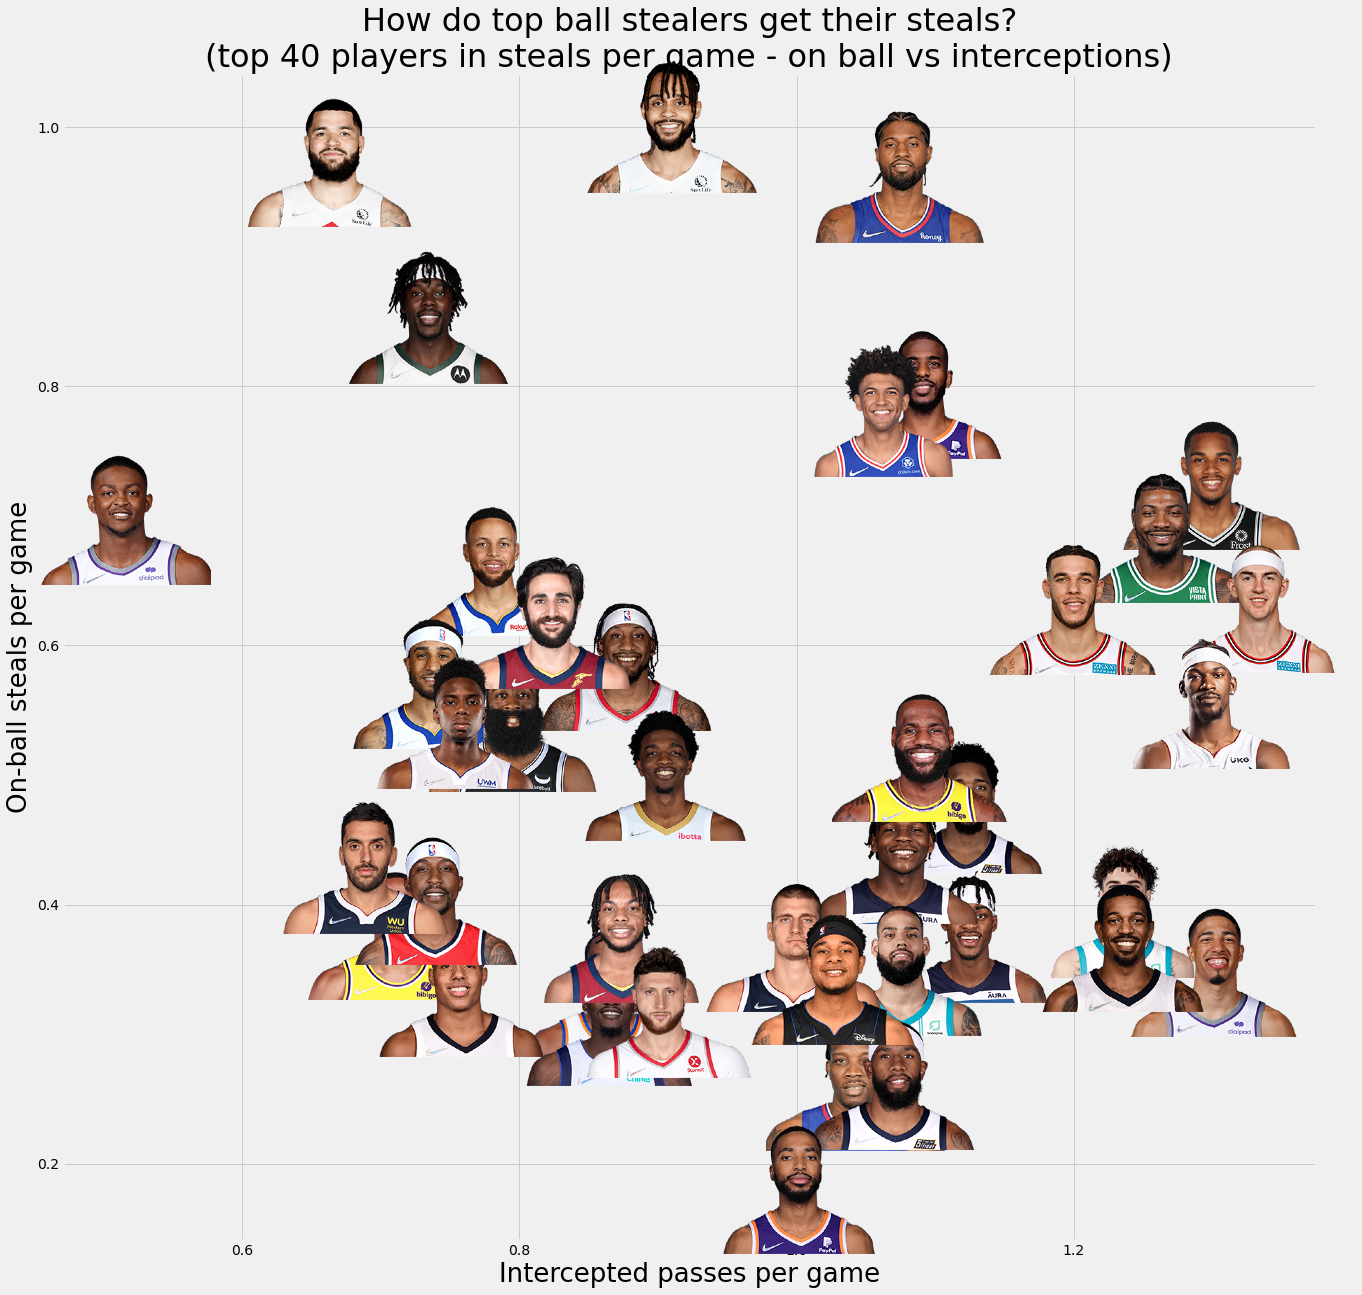

In [23]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(top_players.BAD_PASS_STEAL_G, y=top_players.LOST_BALL_STEAL_G, s=10)

for i in range(len(top_players)):
    item = top_players.iloc[i]
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.BAD_PASS_STEAL_G, item.LOST_BALL_STEAL_G), frameon=False)
    ax.add_artist(ab)
    

ax.set_ylabel("On-ball steals per game", size=26)
ax.set_xlabel("Intercepted passes per game", size=26)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title("How do top ball stealers get their steals?\n(top 40 players in steals per game - on ball vs interceptions)", size=32)

Text(0.5, 1.0, 'How do top ball stealers get their steals?\n(top 40 players in steals per game - on ball vs interceptions)')

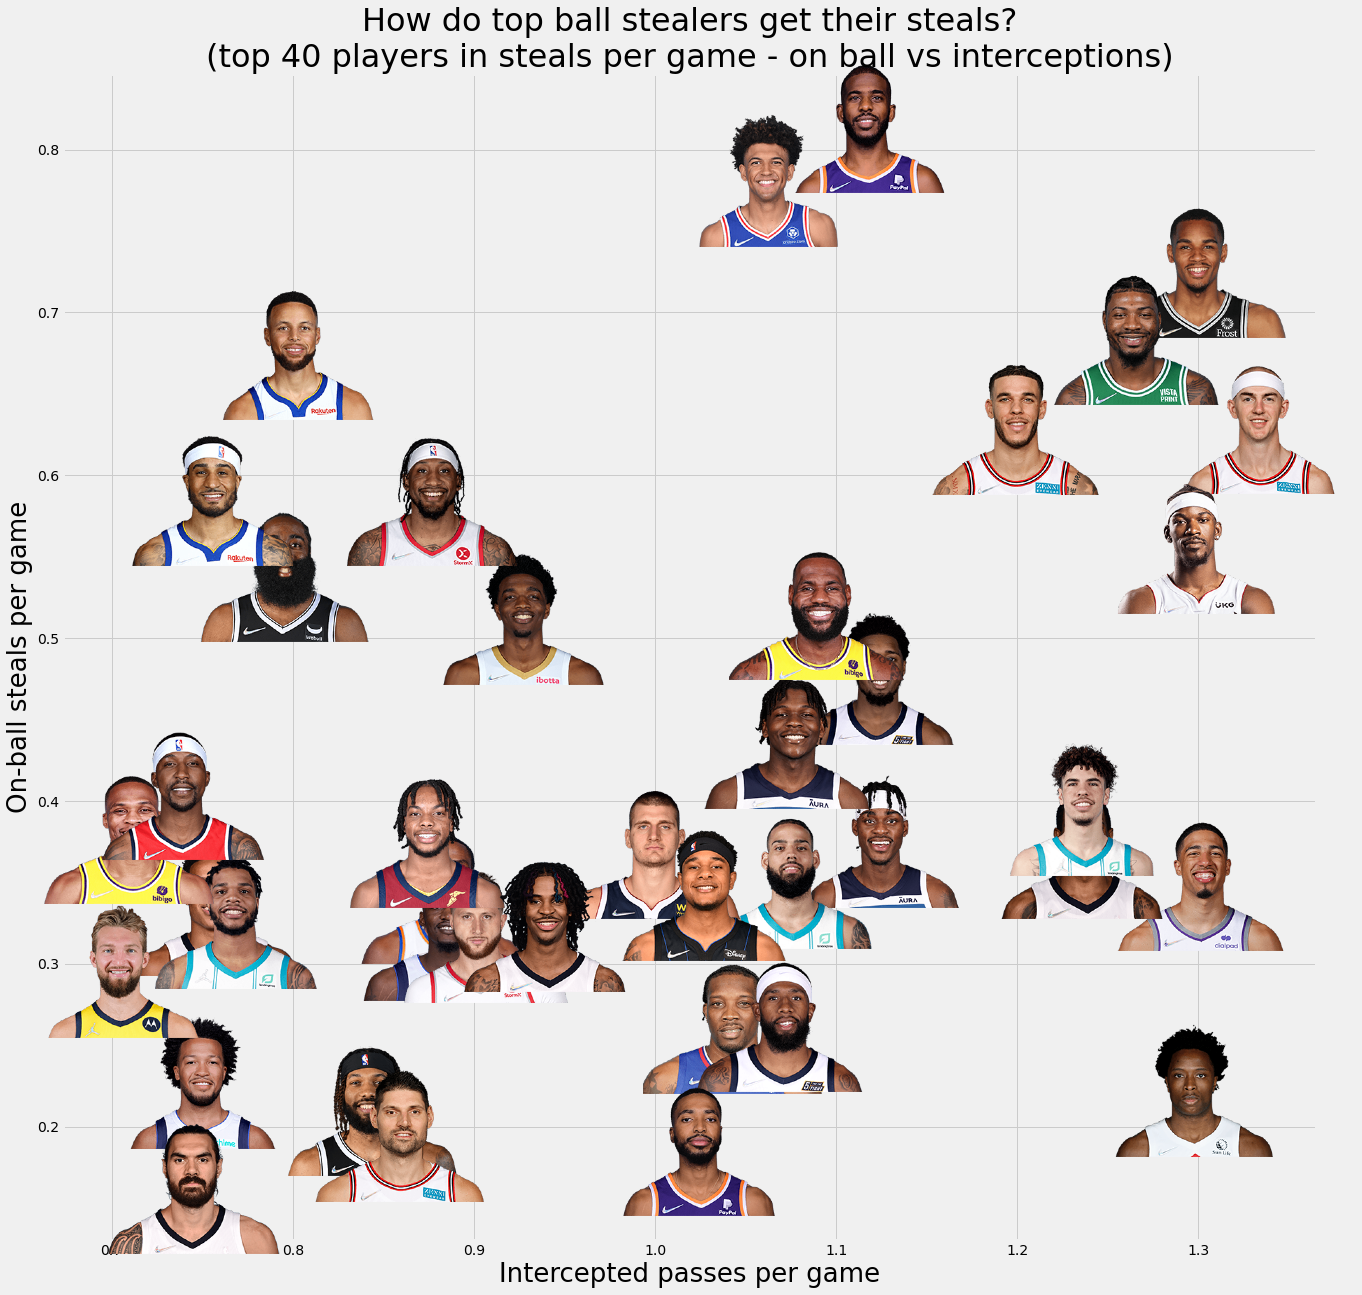

In [62]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(top_players.BAD_PASS_STEAL_G, y=top_players.LOST_BALL_STEAL_G, s=10)

for i in range(len(top_players)):
    item = top_players.iloc[i]
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.BAD_PASS_STEAL_G, item.LOST_BALL_STEAL_G), frameon=False)
    ax.add_artist(ab)
    

ax.set_ylabel("On-ball steals per game", size=26)
ax.set_xlabel("Intercepted passes per game", size=26)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title("How do top ball stealers get their steals?\n(top 40 players in steals per game - on ball vs interceptions)", size=32)